# BASIC STEPS FOR CLEANING AND EXPLORATORY DATA ANALYSIS

This notebook contain the main basic steps that should be performed during exploratory data analysis of experimental data for protein engineering. It is important to note that this is not an exhaustive procedure. It only include the minimal number of steps that should be performed and further steps might be required depending on the specific characteristics of the raw data and objective.

# 1. Cleaning the labeled data

The firsts part of this tutorial includes the exploration and understanding of the experimental label of the data

In [2]:
import pandas as pd
import numpy as np  
import plotly.express as px
import sys
import seaborn as sns

sys.path.insert(0, '../src/')
from data_processing import MeanAndStd, DataOutliers, LogarithmicTransform

A dummy data set was created for the porpuse of demostration.

In [6]:
df = pd.DataFrame({
    'ID': [f'Variant_{i}' for i in range(1, 21)],
    'property_value_R1': [10, 12.7, 14, 13.4, 13, 500, 11.1, 14, 13, 13, 8, 11.1, 12.5, 16, 25, 10.1, 12, 18, 3, 0.01],
    'property_value_R2': [11, 13, 11, 13.3, 12, 600, 11.2, 15, 12, 12, 9, 11.9, 12.2, 13, 20, 10.8, 14, 18.4, 4, 0.02],
    'property_value_R3': [9, 12.1, 11.2, 13.1, 11, 400, 11.3, 14, 13, 12, 10, 12, 12.4, 17, 21, 10.9, 16, 19, 5, 0.03]
})

df.head()

,ID,property_value_R1,property_value_R2,property_value_R3
0,Variant_1,10.0,11.0,9.0
1,Variant_2,12.7,13.0,12.1
2,Variant_3,14.0,11.0,11.2
3,Variant_4,13.4,13.3,13.1
4,Variant_5,13.0,12.0,11.0


When the experimental data contains multiple biological replicates calculate the mean and the standard deviation for each entry before proceding with any additional step.

In [7]:
calculator = MeanAndStd(df)

mean, std = calculator.get_mean_and_std(['property_value_R1', 'property_value_R2', 'property_value_R3'])

df['Mean'] = mean
df['Std'] = std

df.head()

,ID,property_value_R1,property_value_R2,property_value_R3,Mean,Std
0,Variant_1,10.0,11.0,9.0,10.000000,1.000000
1,Variant_2,12.7,13.0,12.1,12.600000,0.458258
2,Variant_3,14.0,11.0,11.2,12.066667,1.677299
3,Variant_4,13.4,13.3,13.1,13.266667,0.152753
4,Variant_5,13.0,12.0,11.0,12.000000,1.000000


The first step in data cleaning is outliers detection and removal. Is recommended to apply at least 2 methods and compare the results. In this tutorial we are using Z-Score and IQR methods.

In [8]:
outlier_detector = DataOutliers(df)

outlier_detector.detect_outliers_and_report('Mean', 'ID', std_dev=df['Std'])

NOTE: In GitHub Plotly figures are not visible

In the above figure there is only 1 true outlier (variant 6). This is beacuse it is identified as an outlier by both methods but also it has a standard deviation of 100 units. On the contrary, variants 15, 19 and 20 are also identified as outliers by the IQR method but the standard deviation of the replicates is considerably low. This means that it is highly likely that there is a biological variability associated with these variants an they should be kept in the dataset. However, when no replicate data is available, this assesment becomes impossible. In such cases is better to keep the entire dataset without outlier removal. 

IMPORTANT! Apart from outliers NaN and other invalid data must be removed from the dataset during the cleaning phase

Before continuing with the data exploration, transform the labels to a logarithmic scale to ease the interpretability and get better insights from the exploratory data analysis.

In [9]:
transformer = LogarithmicTransform(df)

transformed_data = transformer.transform_to_logarithmic('Mean', 12) # 12 is a hypothetical value for the wildtype
df ['Log_property'] = transformed_data
df.head()

,ID,property_value_R1,property_value_R2,property_value_R3,Mean,Std,Log_property
0,Variant_1,10.0,11.0,9.0,10.000000,1.000000,-0.182322
1,Variant_2,12.7,13.0,12.1,12.600000,0.458258,0.048790
2,Variant_3,14.0,11.0,11.2,12.066667,1.677299,0.005540
3,Variant_4,13.4,13.3,13.1,13.266667,0.152753,0.100348
4,Variant_5,13.0,12.0,11.0,12.000000,1.000000,0.000000


This final tranformation of the labels to a logarithmic score allows easier interpretation of the data as a positive value means improved variant, negative mean non beneficial mutation and zero means no change with respect to the wildtype.

# 2. Exploratory data analysis

This part of the notebook contains a set of basic steps for exploratory data analysis of protein variant data. Further steps might be required depending on the complexity of the respective dataset. A synthetic dataset was generated for demostration porposes.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [1]:
from create_synthetic_data import ProteinVariantGenerator

In [2]:
generator = ProteinVariantGenerator(n_samples=1000)
data = generator.generate_data_frame()
data.head()

,ID,Position,Distance_AS,Secondary_structure,Log_fitness
0,E328A,328,15.09,beta,1.497
1,E378W,378,2.65,coil,0.862
2,H48K,48,10.60,alpha,-4.295
3,V367Q,367,5.19,loop,2.523
4,A446H,446,14.26,turn,0.766


The first step of the exploratory data analysis is to obtain the data types and compute general statistics to get a grasp of the data at hand. Also plot distributions for numerical variables and frecuencies for categorical variables.

In [3]:
data.dtypes

ID                      object
Position                 int64
Distance_AS            float64
Secondary_structure     object
Log_fitness            float64
dtype: object

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Position,1000.0,246.209000,140.798606,1.00,123.75000,242.000,365.0000,500.00
Distance_AS,1000.0,10.603660,5.452203,1.01,5.97000,10.620,15.3225,19.99
Log_fitness,1000.0,-1.744232,2.490020,-7.00,-3.63225,-1.881,0.4080,3.00


In [10]:
numeric_features = list(data.select_dtypes(include=['float64', 'int64']))
categorical_features = list(data.select_dtypes('object'))
categorical_features.remove('ID')

print(f'Numerical_features:\n{numeric_features}\n\nCategorical_features:\n{categorical_features}')

Numerical_features:
['Position', 'Distance_AS', 'Log_fitness']

Categorical_features:
['Secondary_structure']


Position...

Skew:  0.04


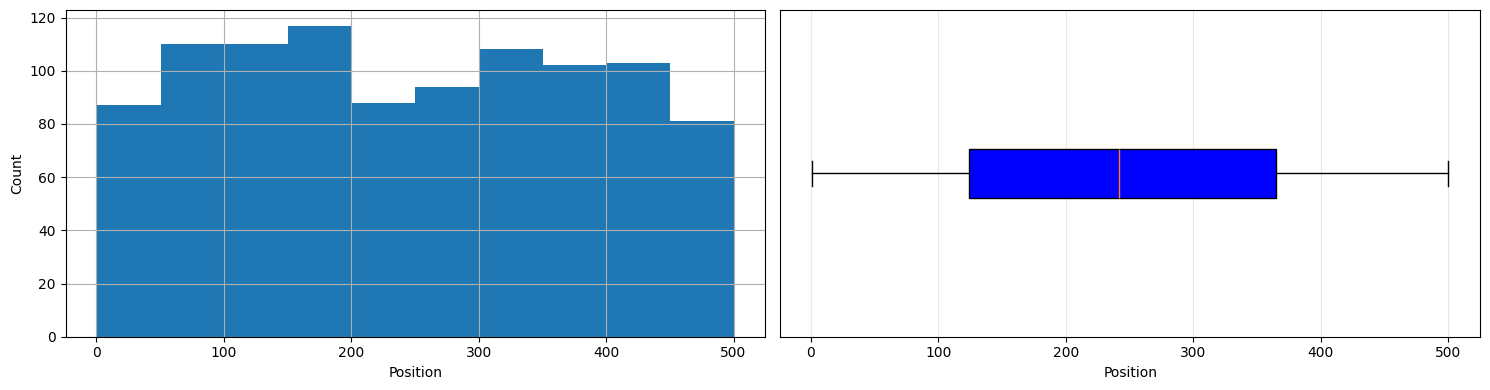

Distance_AS...

Skew:  -0.02


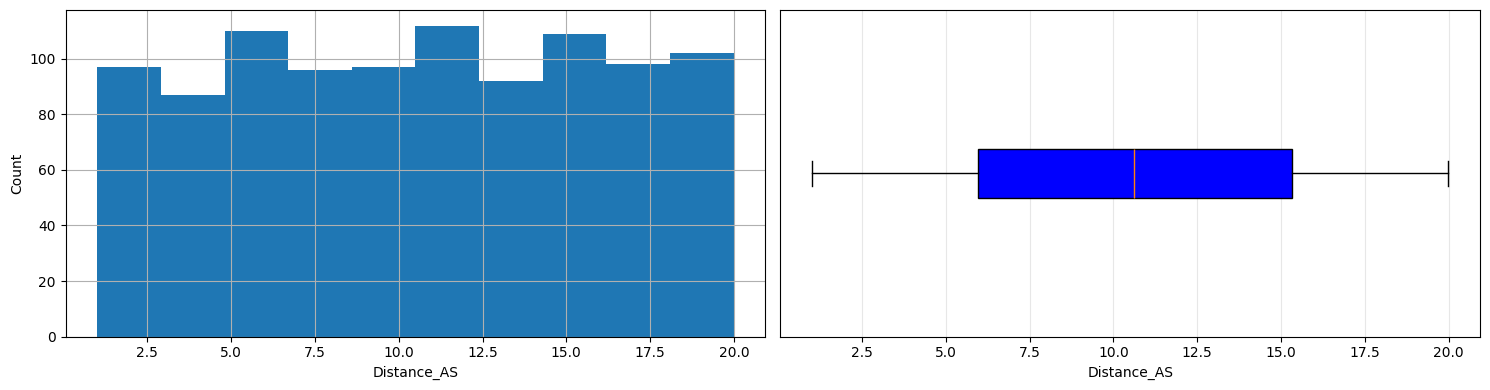

Log_fitness...

Skew:  -0.08


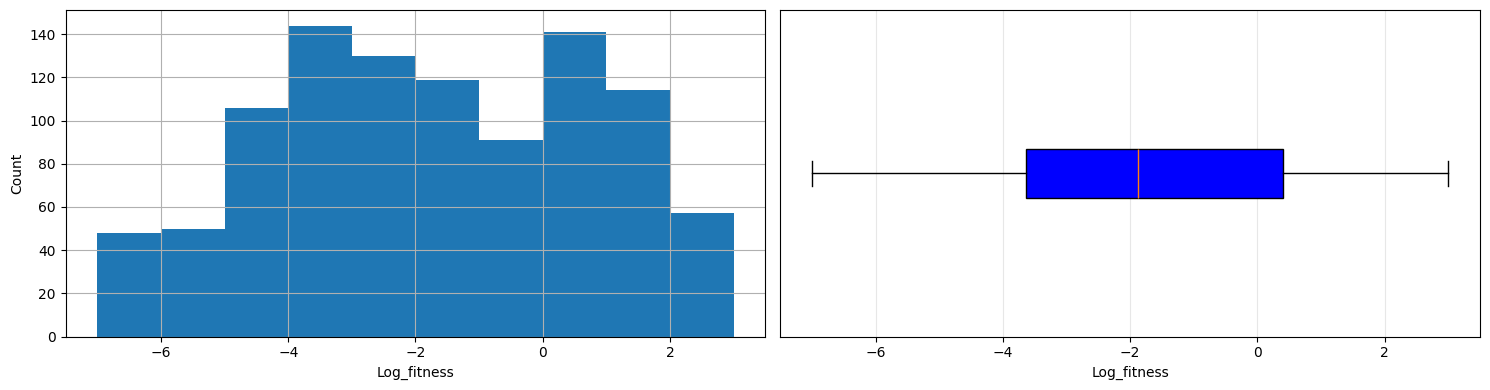

In [18]:
for feature in numeric_features:
    print(f'{feature}...\n')
    print('Skew: ', round(data[feature].skew(), 2))
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 2, 1)
    data[feature].hist()
    plt.xlabel(feature)  
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(
        x=data[feature],
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor='blue'),
        flierprops=dict(
            marker='o',
            markerfacecolor='red',
            markersize=8,
            markeredgecolor='black'
        )
    )
    plt.xlabel(feature)
    plt.yticks([])
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

<Axes: xlabel='count', ylabel='Secondary_structure'>

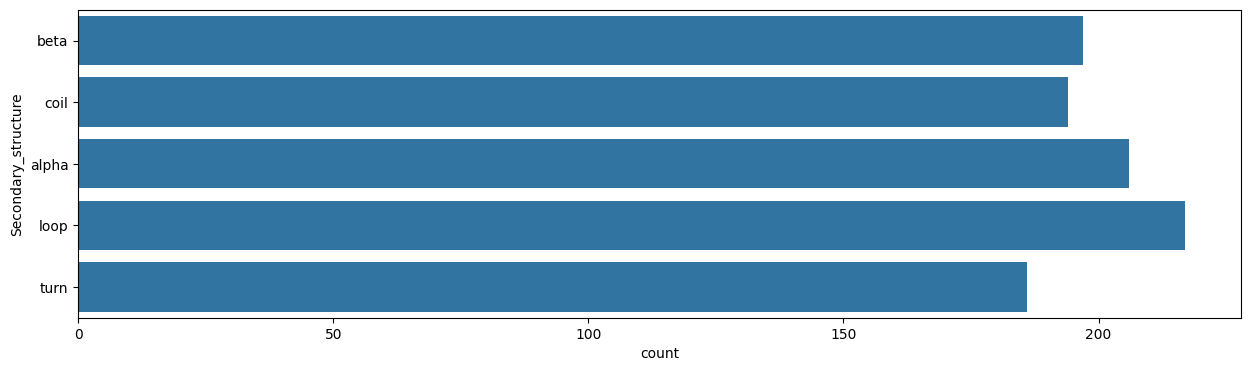

In [25]:
plt.figure(figsize=(15, 4))
sns.countplot(data['Secondary_structure'])

These general statistics and distribution provide a general overview of the data. When looging at the position both from the statistic table and the figures can be observed that the mutations are evenly distributed through the entire sequence. The minimun distance to the active site is 1.01 and the maximun 19.99. Inside this range there is an uniform distribution of the distance. Finally, the fitness (target property) shows an imbalance in the dataset towards non-beneficial mutations as ~70% of the data has negative logarithmic scores. This means that most muatations in the dataset lead to a decrease in the fitness with respect to the wildtype. This imbalance must be address properly.